# Opportunity 2

## Imports

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
from fbprophet import Prophet

warnings.simplefilter('ignore')

## Data setup

In [9]:
data_dir = Path('data')
stores_data = {}

for parquet_file in data_dir.glob('*.parquet*'):
    file_name = str(parquet_file).replace('data\sales-', '').replace('.parquet.gzip', '')
    stores_data[file_name] = {'sales_df': pd.read_parquet(parquet_file).drop(['SALES_DIST', 'SOLD_TO', 'SHIP_TO'], axis=1)}
    
stores_data

{'data/sales-7017139': {'sales_df':            BILL_DATE  MATERIAL  PIEZAS
  327623    2019-03-04       425       1
  342880    2019-03-04     12080       1
  343841    2019-03-04      2639       1
  347866    2019-03-04     12026       1
  467020    2019-03-04     29772       2
  ...              ...       ...     ...
  186696013 2021-03-29     12793       2
  186696014 2021-03-29     22054       4
  186908262 2021-03-29     43004       1
  186915466 2021-03-29     16640       1
  186925567 2021-03-29     36717       2
  
  [4379 rows x 3 columns]},
 'data/sales-7003984': {'sales_df':            BILL_DATE  MATERIAL  PIEZAS
  8511      2019-03-03      2641       1
  8512      2019-03-03     12916       1
  8513      2019-03-03      2464       1
  9478      2019-03-03     11074       1
  9479      2019-03-03     20306       1
  ...              ...       ...     ...
  141730332 2020-09-17     31907       2
  141730333 2020-09-17     36526       2
  141730334 2020-09-17     36879       1

## Get first and last date for each store

In [10]:
for store, data in stores_data.items():
    df_sorted_by_dates = data['sales_df'].sort_values(by='BILL_DATE')
    data['oldest_date'] = df_sorted_by_dates.iloc[0]["BILL_DATE"]
    data['newest_date'] = df_sorted_by_dates.iloc[-1]["BILL_DATE"]

## Top 10 most sold products per store

In [11]:
for store, data in stores_data.items():
    product_sales = data['sales_df'].groupby(['MATERIAL'])['PIEZAS'].sum().sort_values(ascending=False)
    data['top_products'] = product_sales.head(10)

stores_data

{'data/sales-7017139': {'sales_df':            BILL_DATE  MATERIAL  PIEZAS
  327623    2019-03-04       425       1
  342880    2019-03-04     12080       1
  343841    2019-03-04      2639       1
  347866    2019-03-04     12026       1
  467020    2019-03-04     29772       2
  ...              ...       ...     ...
  186696013 2021-03-29     12793       2
  186696014 2021-03-29     22054       4
  186908262 2021-03-29     43004       1
  186915466 2021-03-29     16640       1
  186925567 2021-03-29     36717       2
  
  [4379 rows x 3 columns],
  'oldest_date': Timestamp('2019-03-04 00:00:00'),
  'newest_date': Timestamp('2021-03-29 00:00:00'),
  'top_products': MATERIAL
  4101     200
  13165    115
  4124     100
  19197     86
  4373      80
  4102      70
  9664      68
  3953      68
  3954      65
  4108      62
  Name: PIEZAS, dtype: int64},
 'data/sales-7003984': {'sales_df':            BILL_DATE  MATERIAL  PIEZAS
  8511      2019-03-03      2641       1
  8512      2019-0

## Get daily sales of top 10 products of each store

In [12]:
for store, data in stores_data.items():
    idx = pd.date_range(data['oldest_date'], data['newest_date'])
    data['top_products_sales'] = {}
    for product, sale in data['top_products'].iteritems():
        product_series = data['sales_df'][data['sales_df']["MATERIAL"] == product]
        product_series = product_series.groupby('BILL_DATE').PIEZAS.sum().to_frame(name = 'PIEZAS')

        product_series.index = pd.DatetimeIndex(product_series.index)
        product_series = product_series.reindex(idx, fill_value=0)
        product_series.index.name = "BILL_DATE"
        product_series = product_series.reset_index()
        data['top_products_sales'][product] = product_series

stores_data

{'data/sales-7017139': {'sales_df':            BILL_DATE  MATERIAL  PIEZAS
  327623    2019-03-04       425       1
  342880    2019-03-04     12080       1
  343841    2019-03-04      2639       1
  347866    2019-03-04     12026       1
  467020    2019-03-04     29772       2
  ...              ...       ...     ...
  186696013 2021-03-29     12793       2
  186696014 2021-03-29     22054       4
  186908262 2021-03-29     43004       1
  186915466 2021-03-29     16640       1
  186925567 2021-03-29     36717       2
  
  [4379 rows x 3 columns],
  'oldest_date': Timestamp('2019-03-04 00:00:00'),
  'newest_date': Timestamp('2021-03-29 00:00:00'),
  'top_products': MATERIAL
  4101     200
  13165    115
  4124     100
  19197     86
  4373      80
  4102      70
  9664      68
  3953      68
  3954      65
  4108      62
  Name: PIEZAS, dtype: int64,
  'top_products_sales': {4101:      BILL_DATE  PIEZAS
   0   2019-03-04       0
   1   2019-03-05       0
   2   2019-03-06       0
   

## Forecast the next 7 days for each of the top 10 products at each store

In [40]:
for store in stores_data:
    print(f'Store: {store}')
    stores_data[store]['models'] = {}
    stores_data[store]['predictions'] = {}
    stores_data[store]['fbp_objects'] = {}
    for product in stores_data[store]['top_products_sales']:
        print(f'Product: {product}')
        daily_sales = stores_data[store]['top_products_sales'][product]
        daily_sales.columns = ['ds', 'y']
        m = Prophet(interval_width=0.95, daily_seasonality=True, yearly_seasonality=False) 
        stores_data[store]['models'][product] = m.fit(daily_sales)
        future = m.make_future_dataframe(periods=7, freq='D')
        forecast = m.predict(future)
        forecast = forecast.tail(7)
        stores_data[store]['predictions'][product] = forecast
        stores_data[store]['fbp_objects'][product] = m

Store: data/sales-7017139
Product: 4101
Initial log joint probability = -2.69
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       2013.82   1.03747e-05       91.7013   1.118e-07       0.001      132  LS failed, Hessian reset 
      99       2013.82   4.44049e-08       79.5661       0.348       0.348      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       2013.82    1.6798e-07       88.2881           1           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Product: 13165
Initial log joint probability = -2.78656
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       1965.89   4.02349e-08       68.4739      0.2126           1       95   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Produc

## Round forecasted values and turn negative ones into 0

In [41]:
for store in stores_data:
    print(f'Store: {store}')
    for product in stores_data[store]['top_products_sales']:
        print(f'Product: {product}')
        stores_data[store]['predictions'][product]['yhat'] = round(stores_data[store]['predictions'][product]['yhat'])
        stores_data[store]['predictions'][product][stores_data[store]['predictions'][product]['yhat'] <= 0]['yhat'] = 0
        print(stores_data[store]['predictions'][product])

Store: data/sales-7017139
Product: 4101
            ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
757 2021-03-30  0.520879   -7.844335    8.826278     0.520879     0.520879   
758 2021-03-31  0.521483   -8.035923    7.883228     0.521482     0.521483   
759 2021-04-01  0.522086   -7.378700    8.080035     0.522081     0.522089   
760 2021-04-02  0.522690   -7.538724    9.169517     0.522677     0.522698   
761 2021-04-03  0.523293   -8.380497    8.259148     0.523272     0.523306   
762 2021-04-04  0.523897   -7.854367    8.522353     0.523868     0.523918   
763 2021-04-05  0.524500   -7.280256   10.172491     0.524464     0.524527   

     additive_terms  additive_terms_lower  additive_terms_upper     daily  \
757       -0.275565             -0.275565             -0.275565 -0.014196   
758       -0.276263             -0.276263             -0.276263 -0.014196   
759        0.000812              0.000812              0.000812 -0.014196   
760        0.185296        

## Plot models with all data

Store: data/sales-7017139
Product: 4101
Product: 13165
Product: 4124
Product: 19197
Product: 4373
Product: 4102
Product: 9664
Product: 3953
Product: 3954
Product: 4108
Store: data/sales-7003984
Product: 1564
Product: 4373
Product: 3439
Product: 12504
Product: 3008
Product: 6623
Product: 27752
Product: 4077
Product: 7904
Product: 4414
Store: data/sales-7023126
Product: 2541
Product: 29725
Product: 29258
Product: 38054
Product: 20791
Product: 3439
Product: 2342
Product: 12081
Product: 29257
Product: 16869
Store: data/sales-7029898
Product: 4373
Product: 3444
Product: 4103
Product: 1883
Product: 43629
Product: 6248
Product: 44066
Product: 18891
Product: 43598
Product: 15932
Store: data/sales-7007091
Product: 6969
Product: 6207
Product: 6962
Product: 6963
Product: 188
Product: 3591
Product: 3590
Product: 3556
Product: 6213
Product: 22572
Store: data/sales-7022906
Product: 15590
Product: 21256
Product: 8650
Product: 18761
Product: 28727
Product: 32002
Product: 28725
Product: 8657
Product: 2

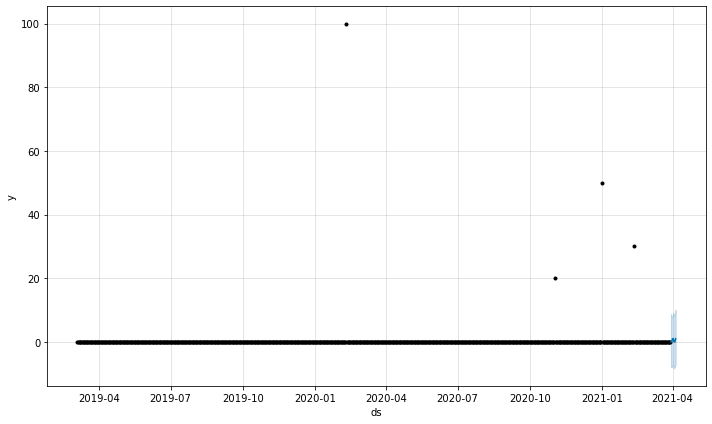

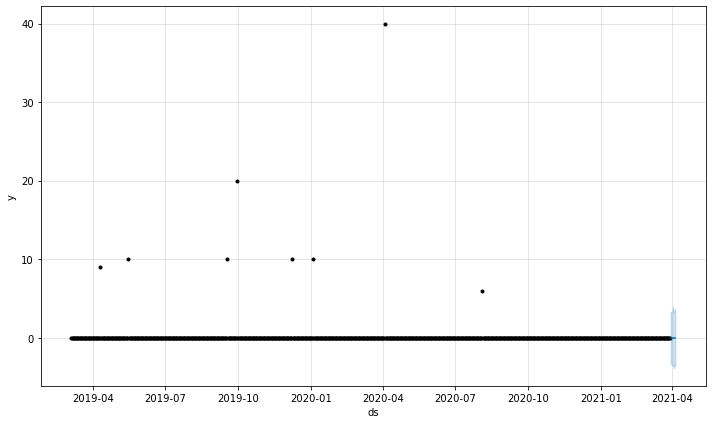

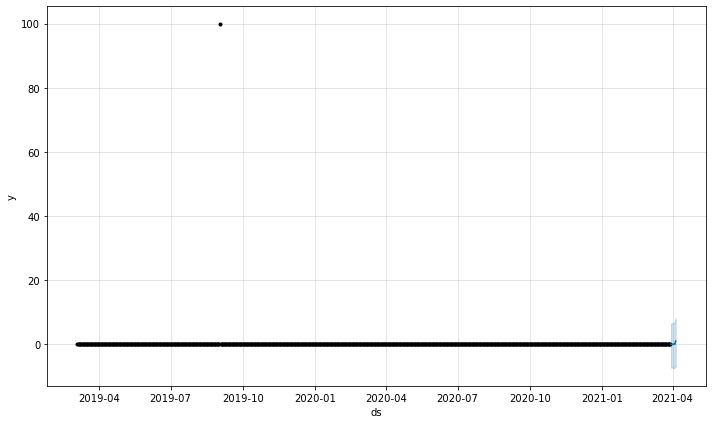

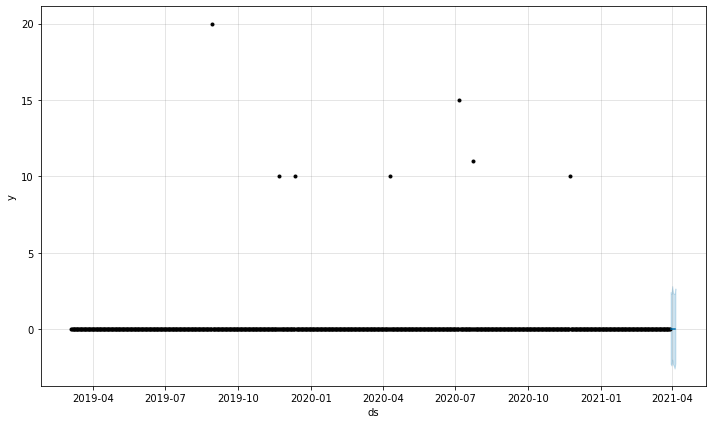

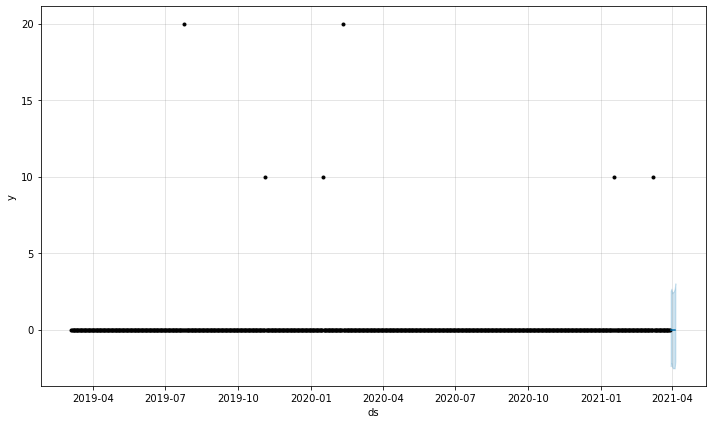

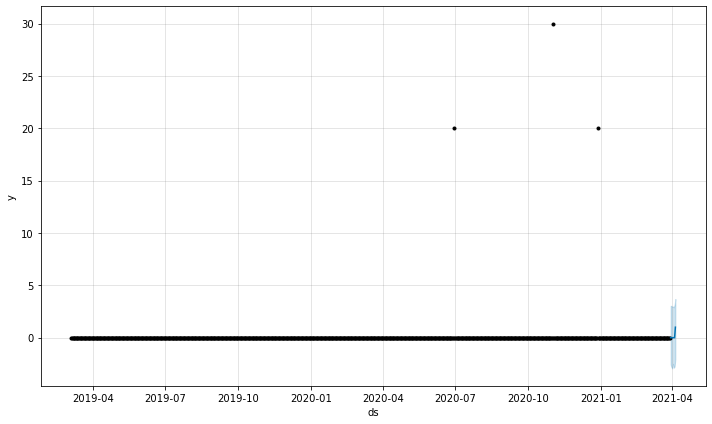

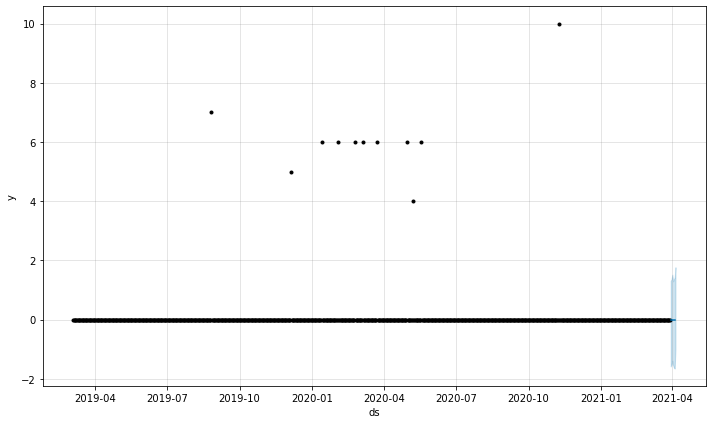

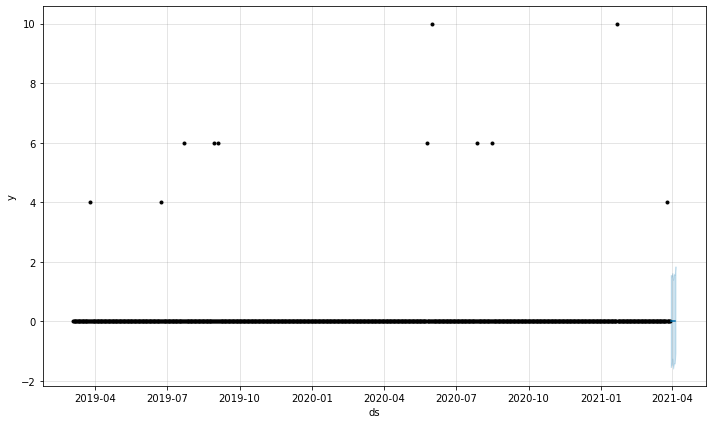

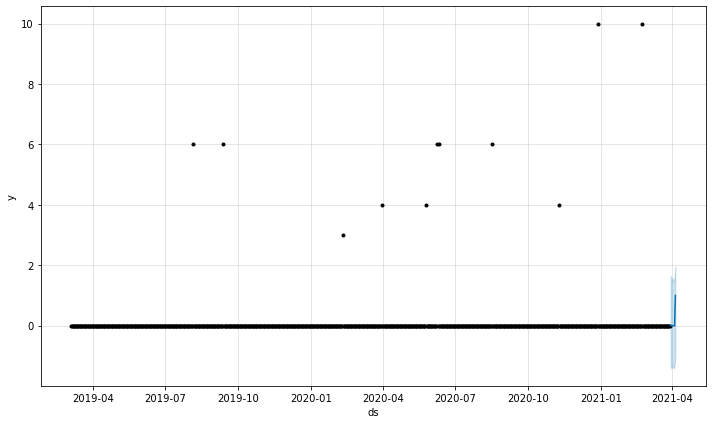

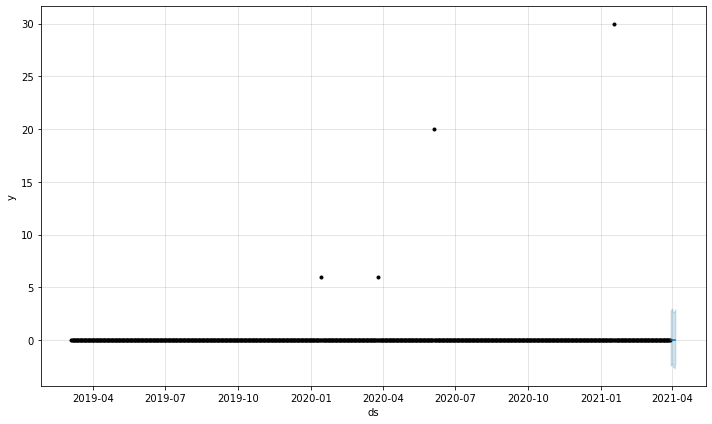

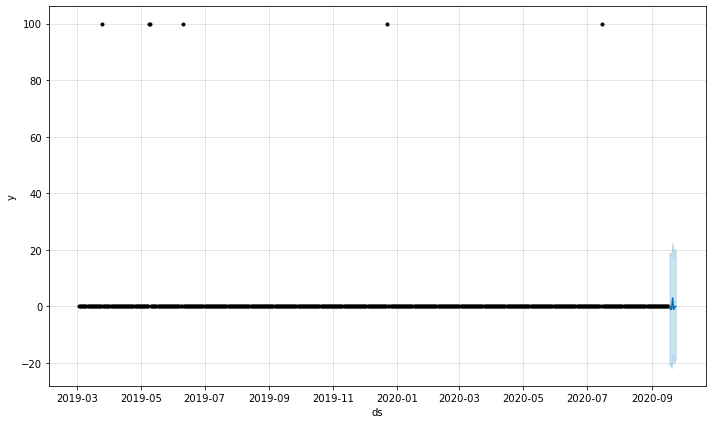

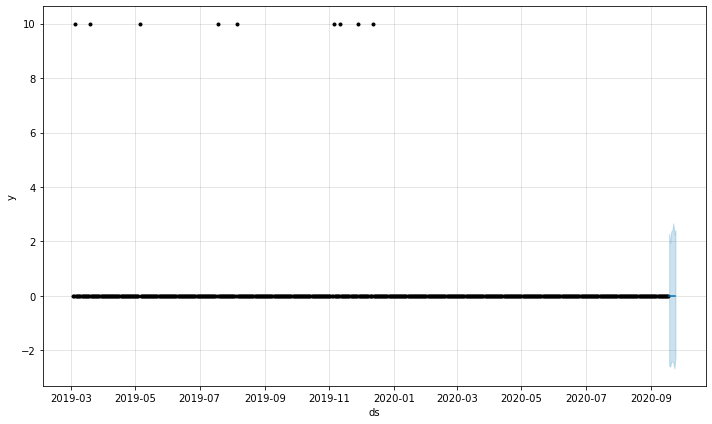

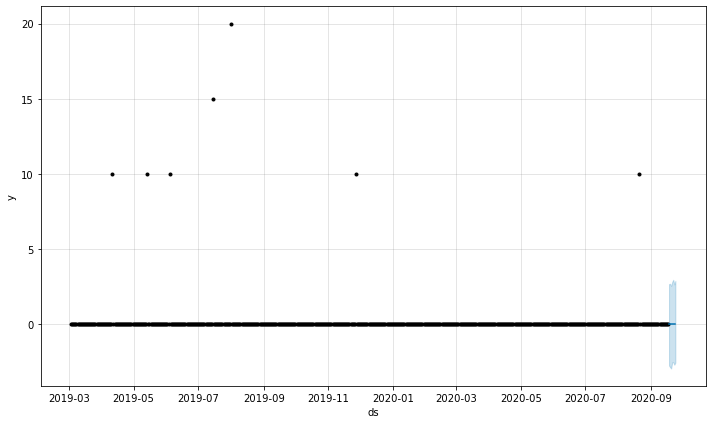

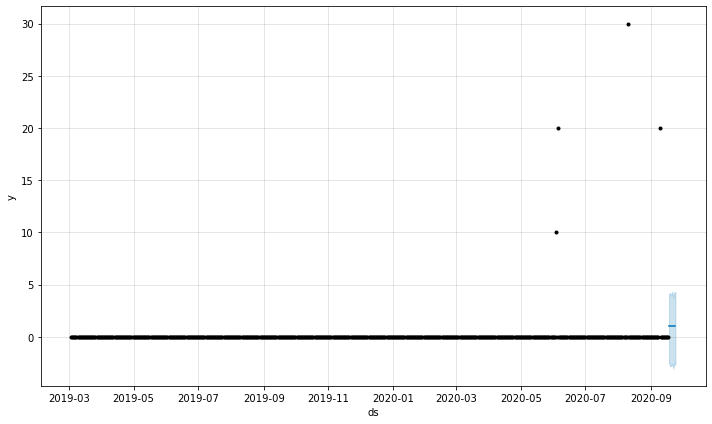

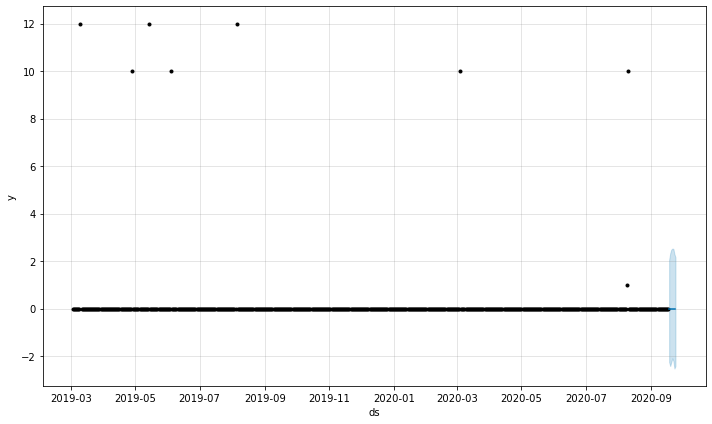

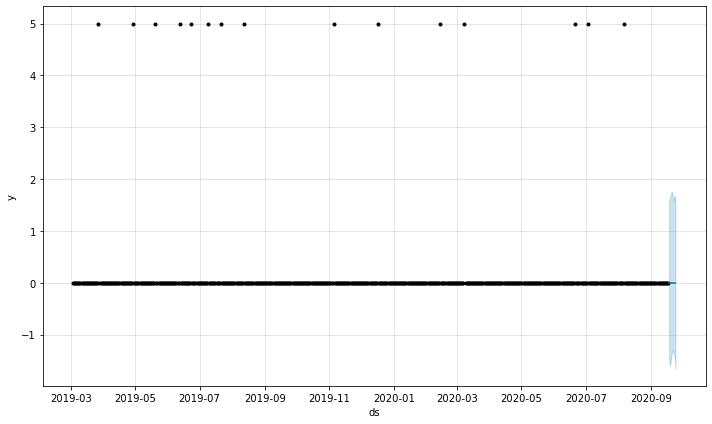

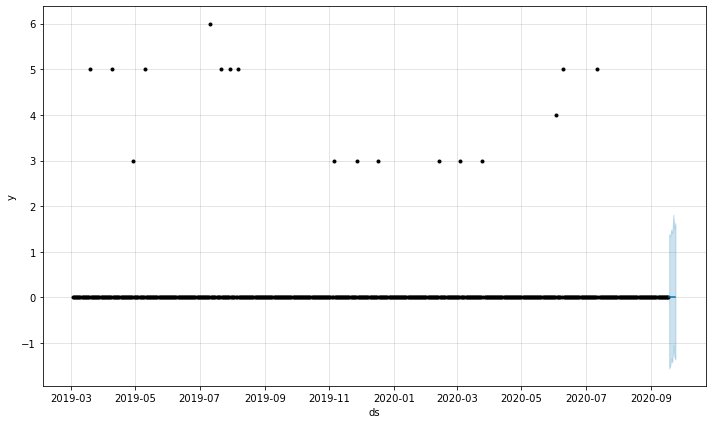

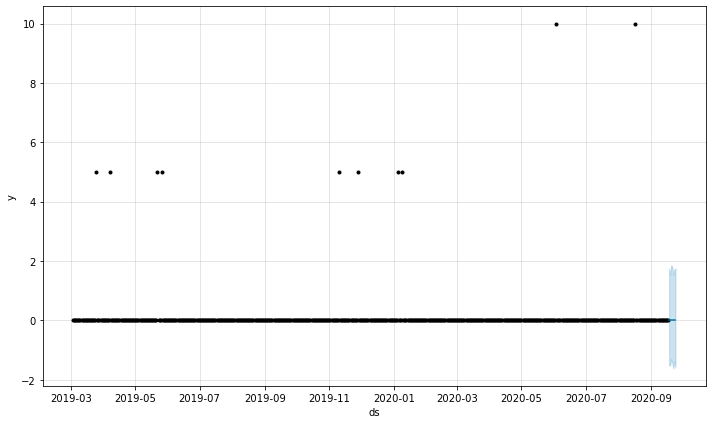

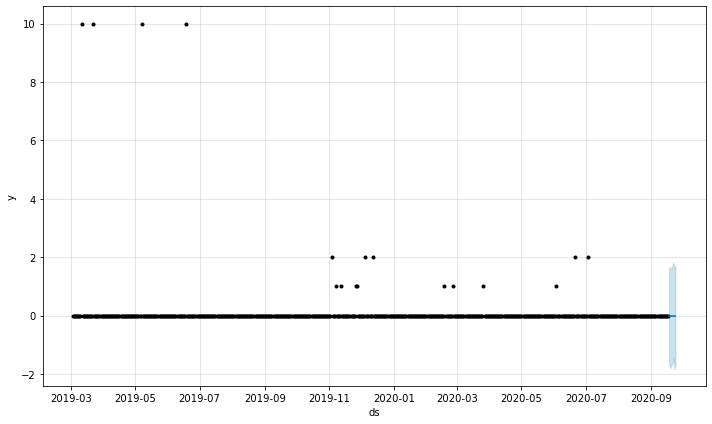

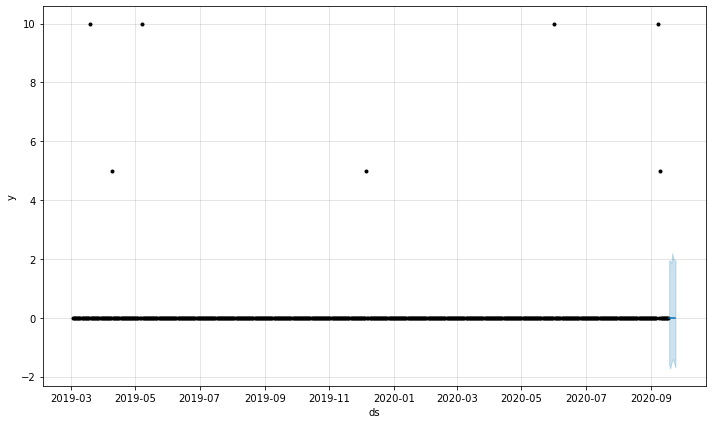

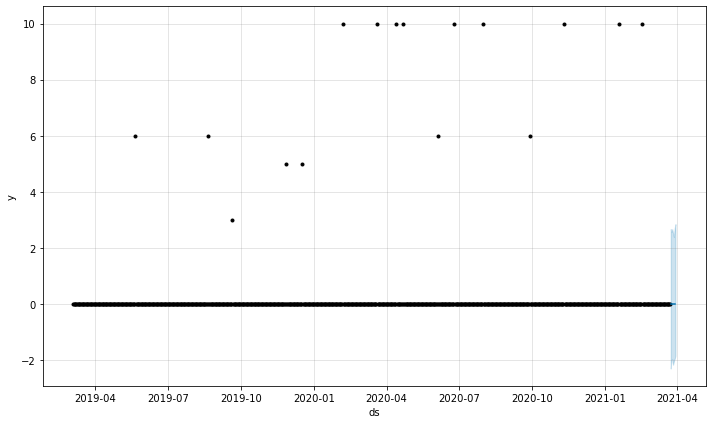

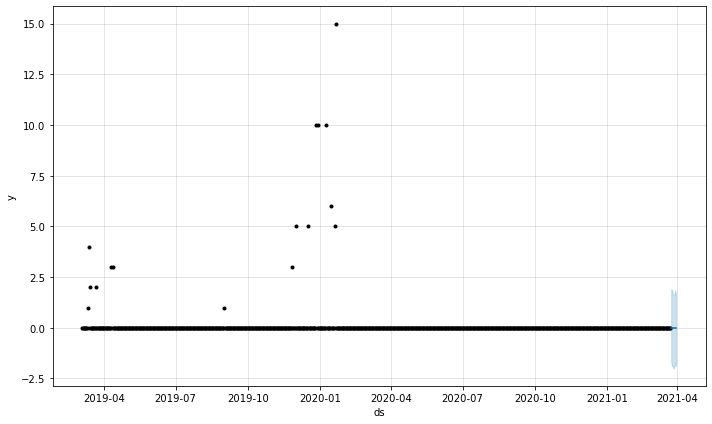

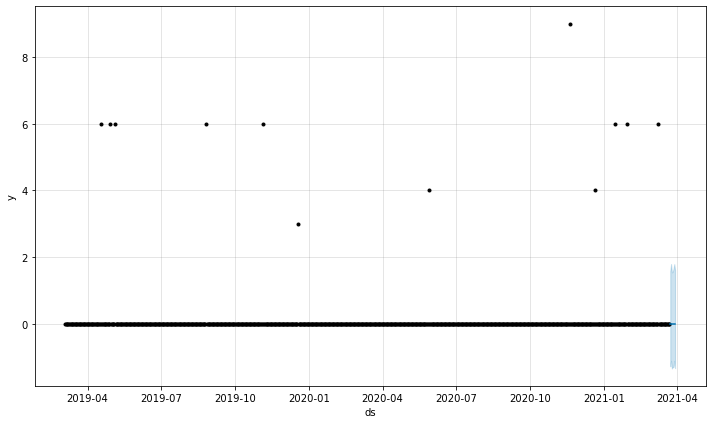

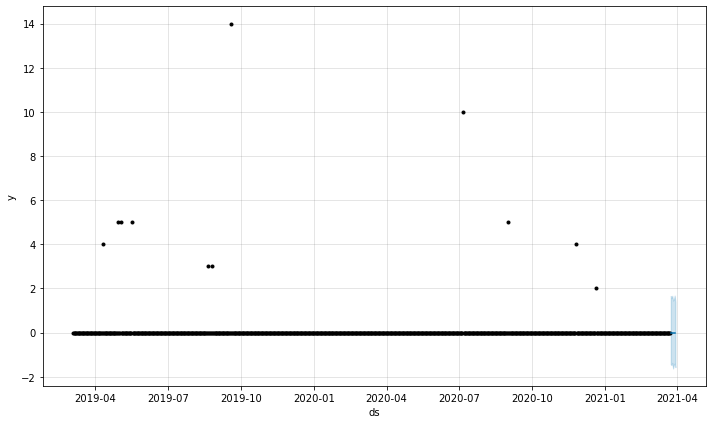

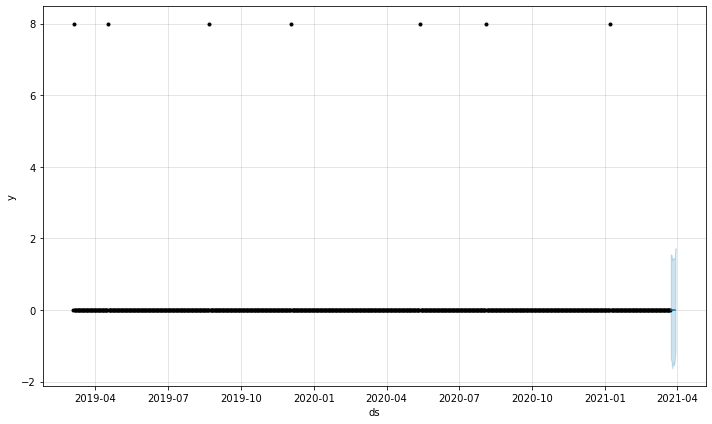

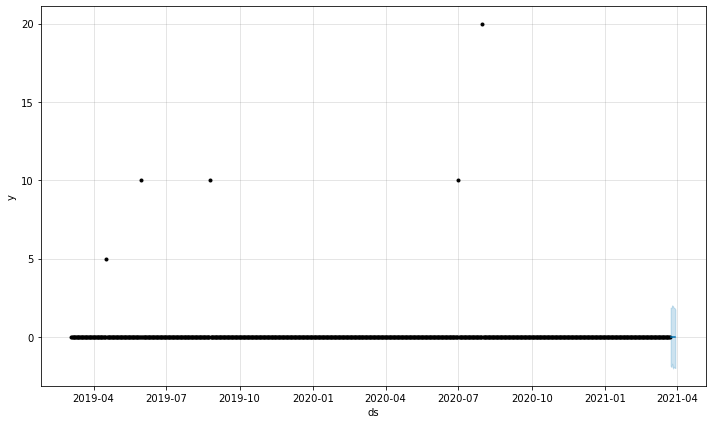

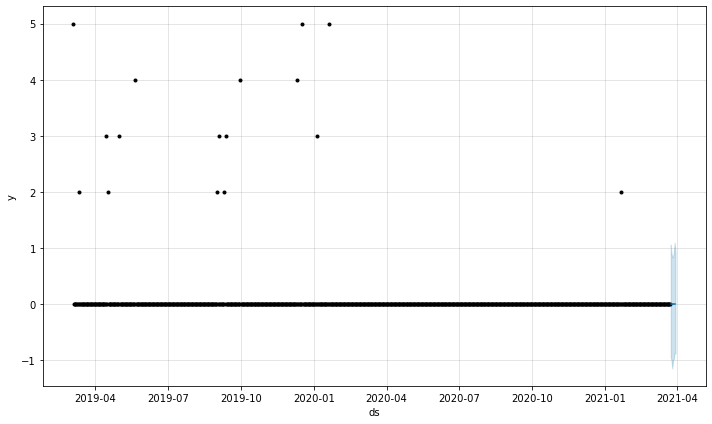

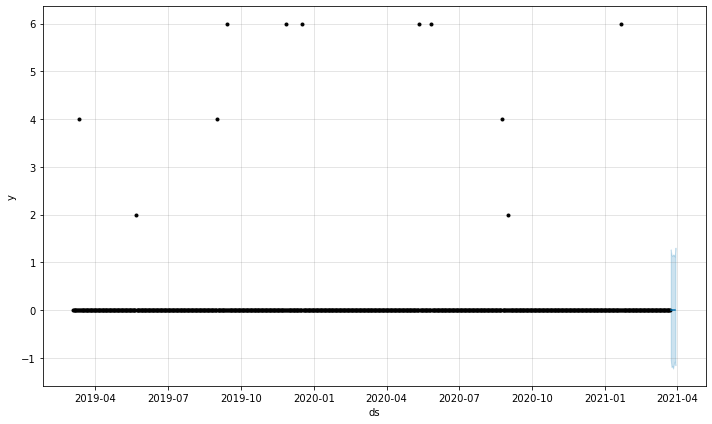

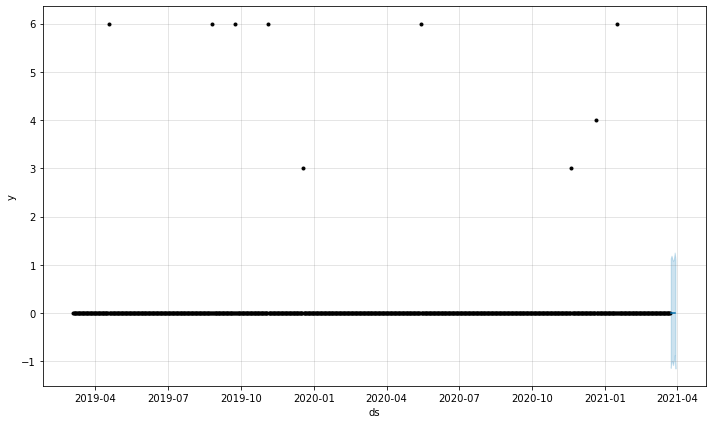

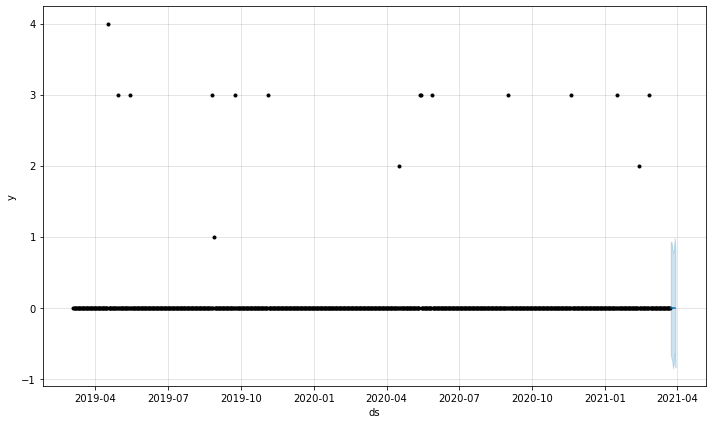

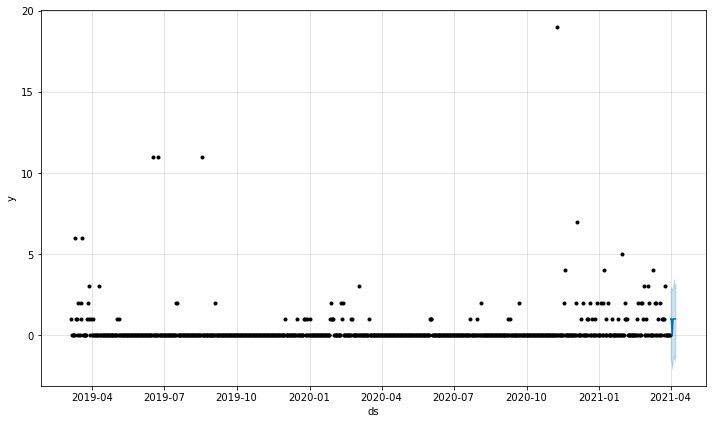

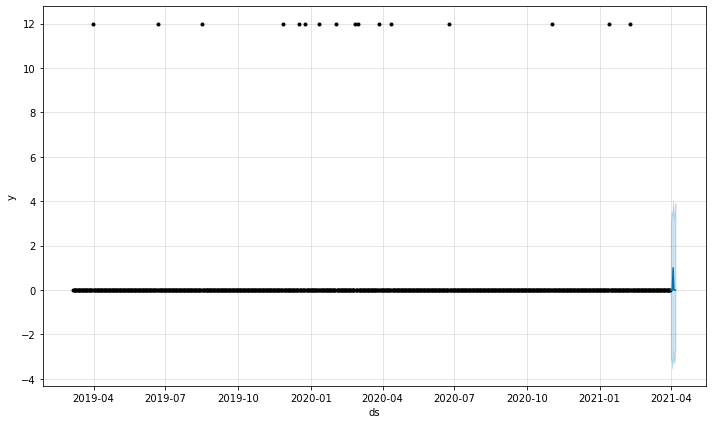

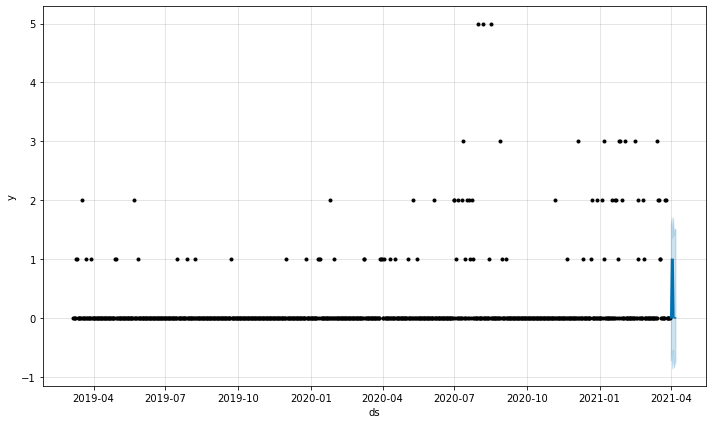

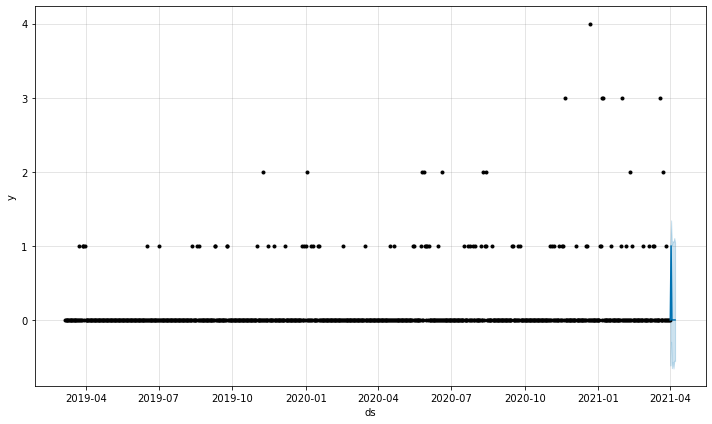

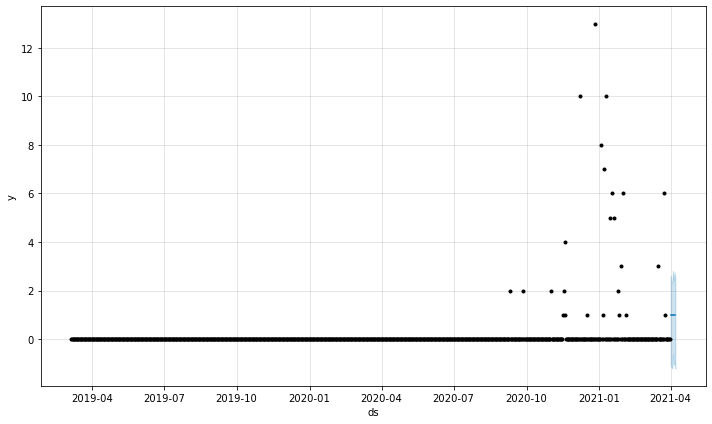

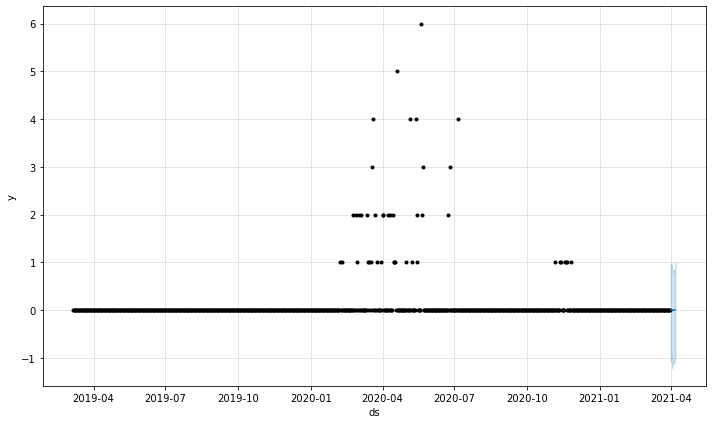

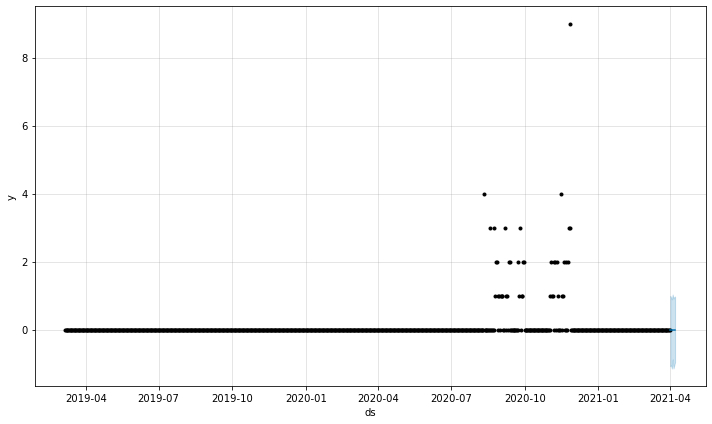

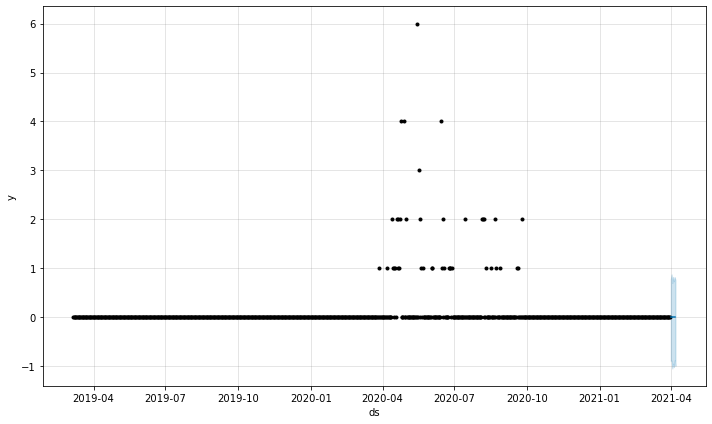

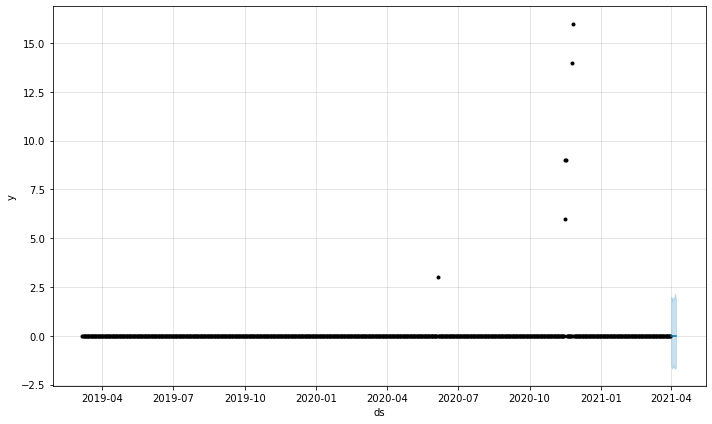

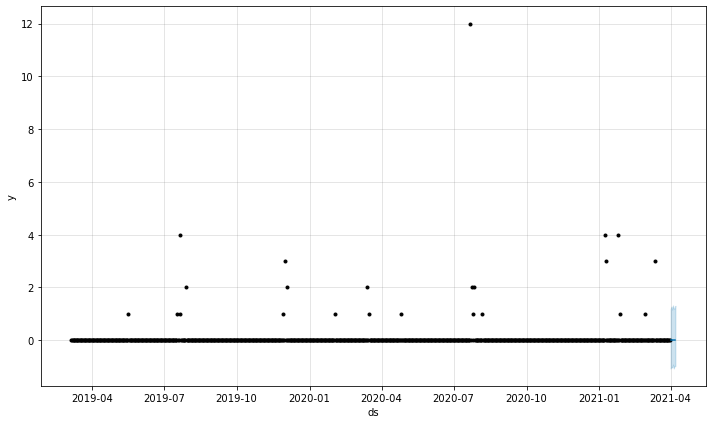

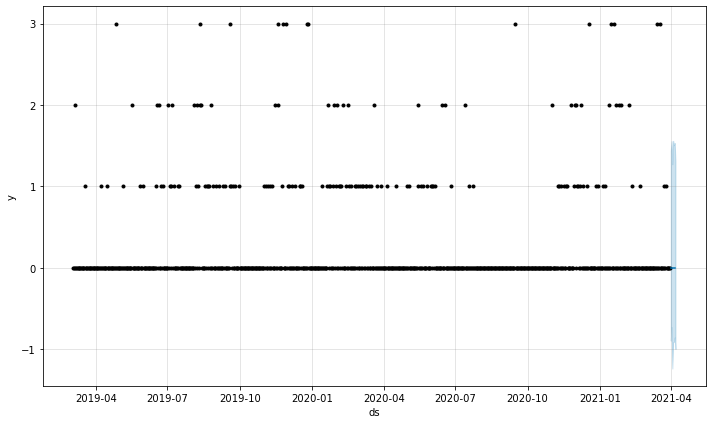

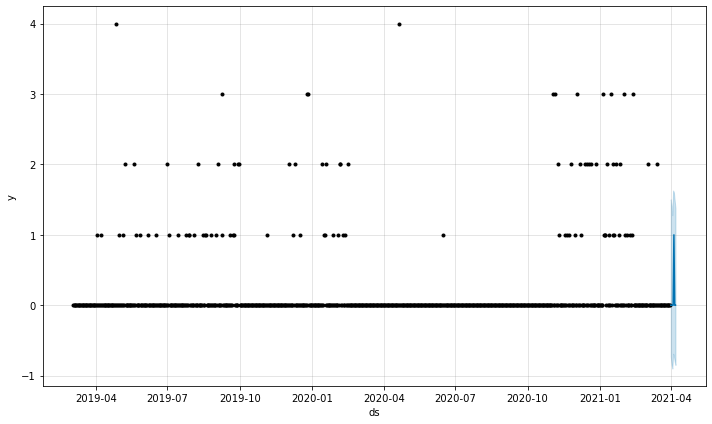

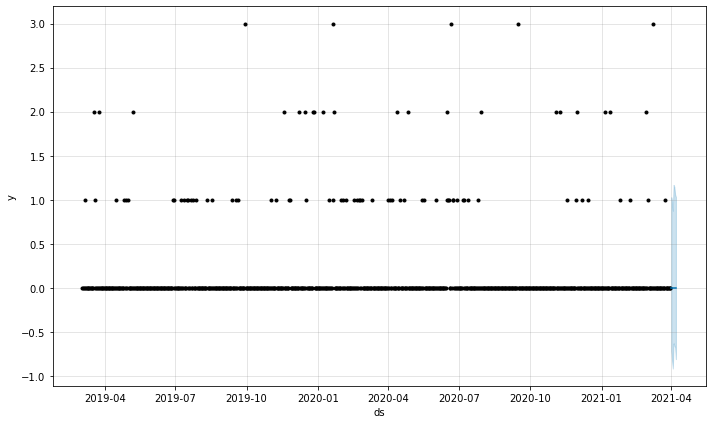

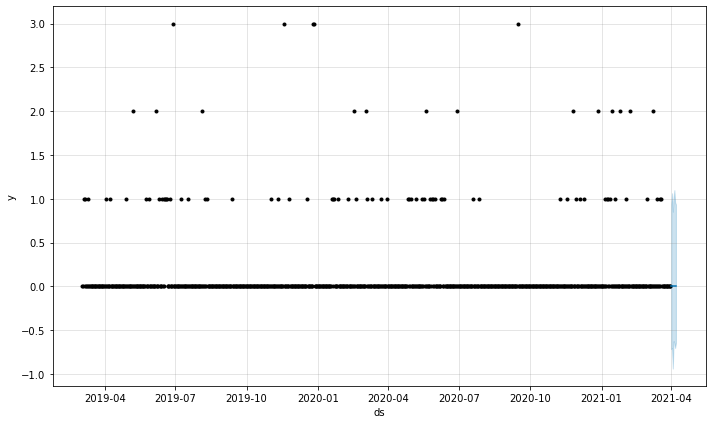

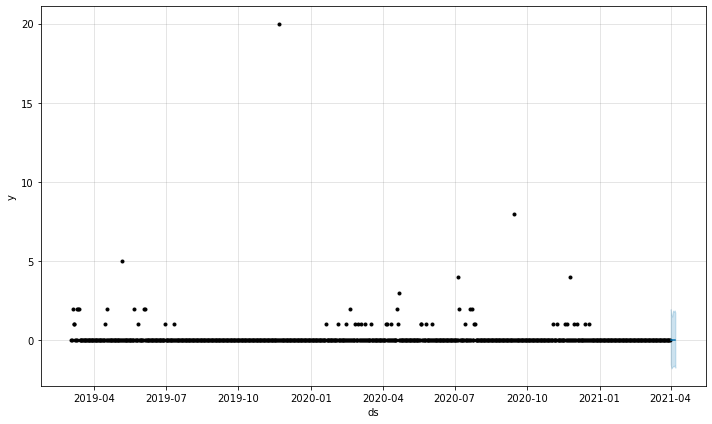

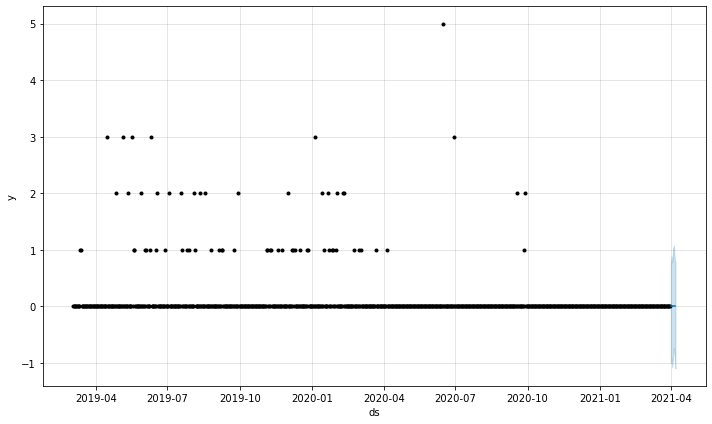

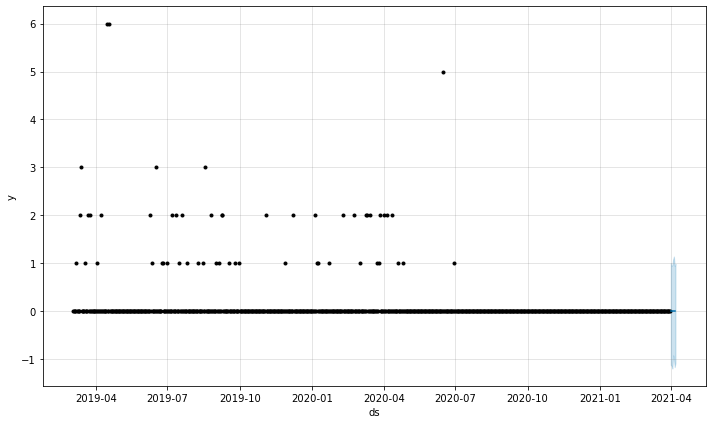

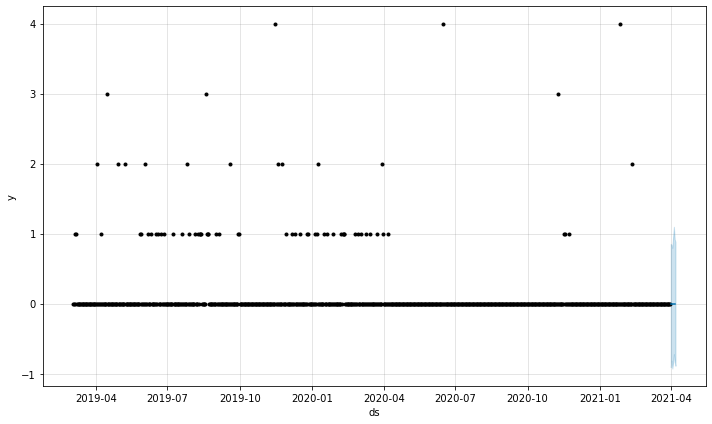

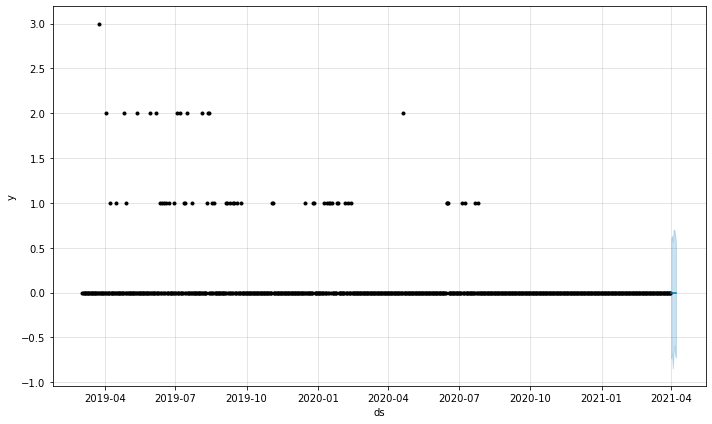

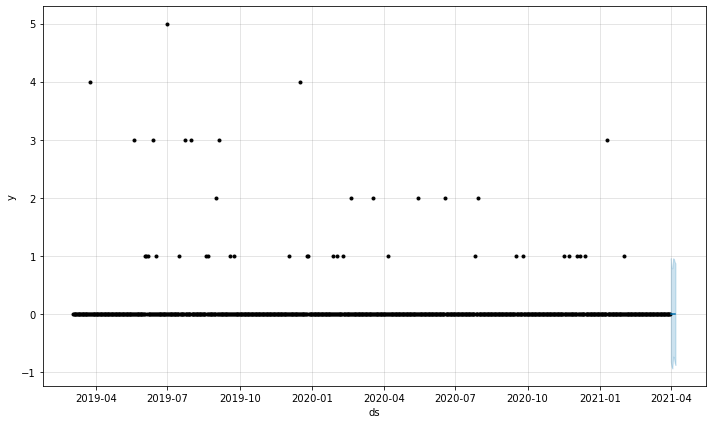

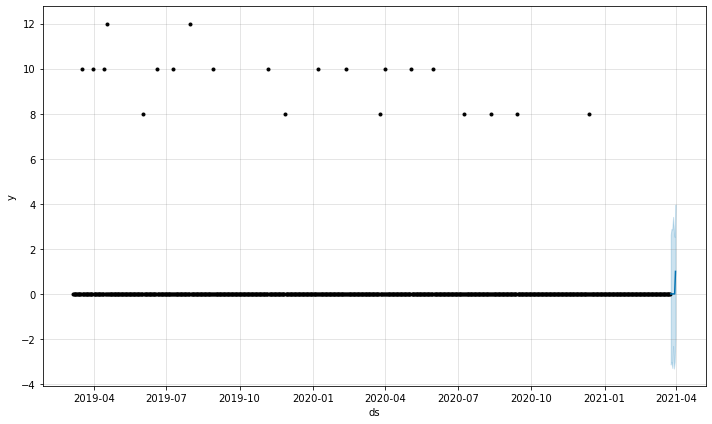

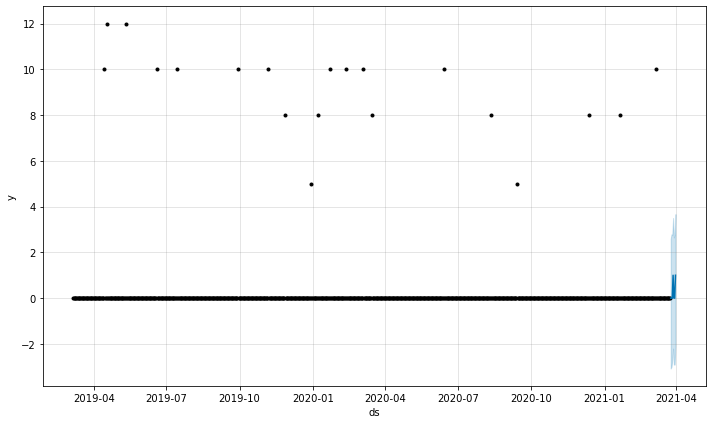

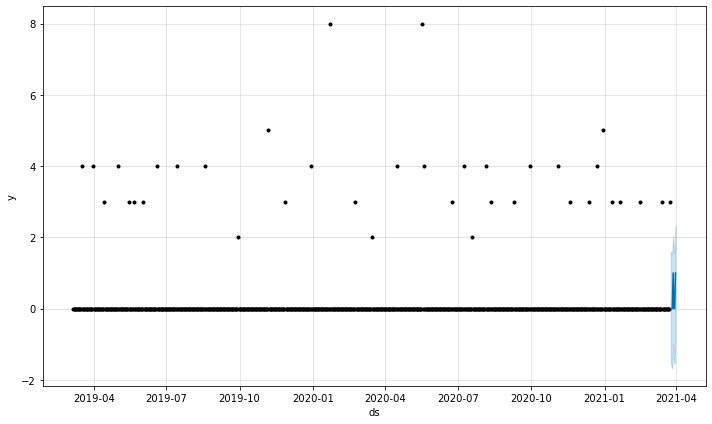

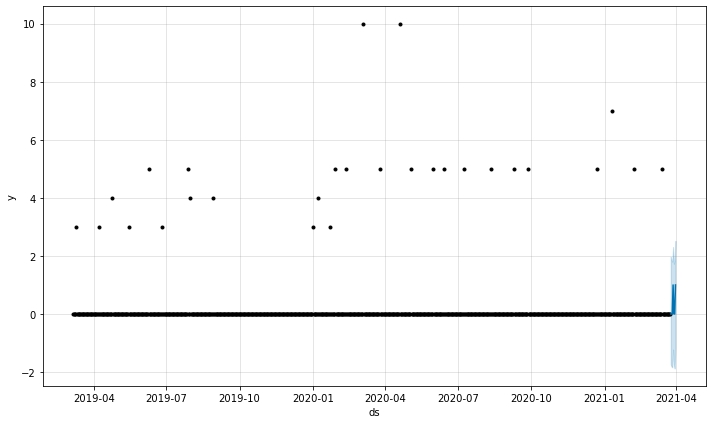

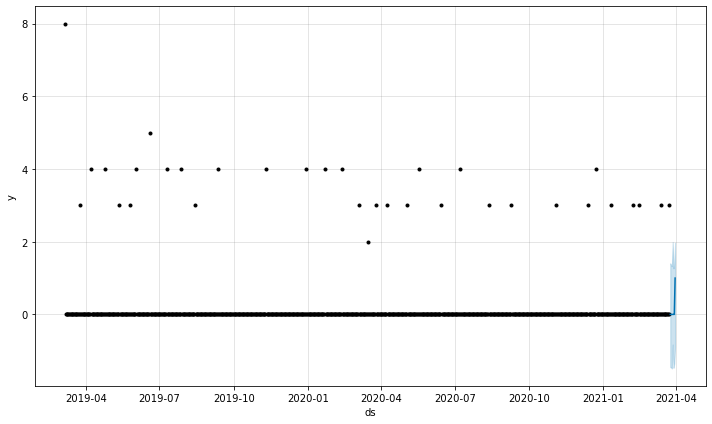

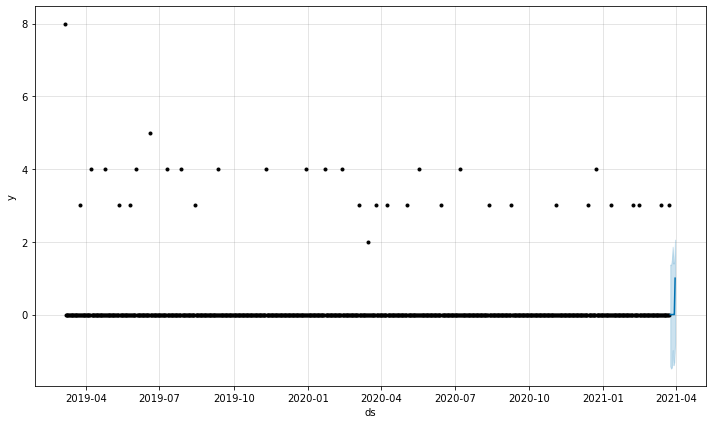

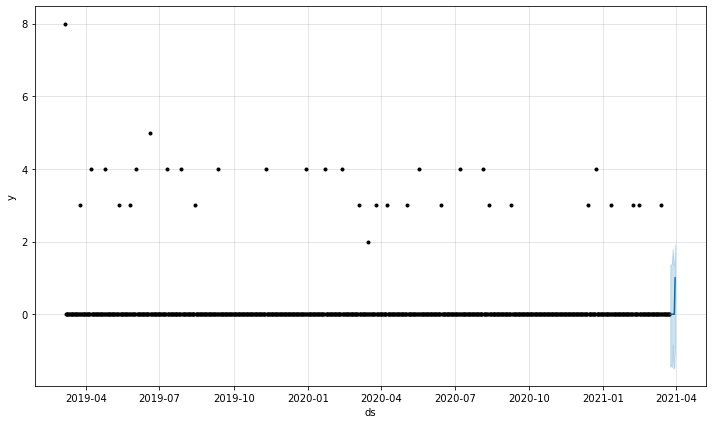

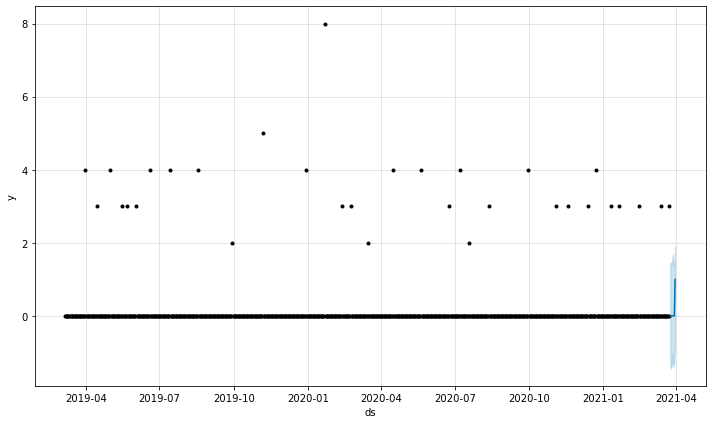

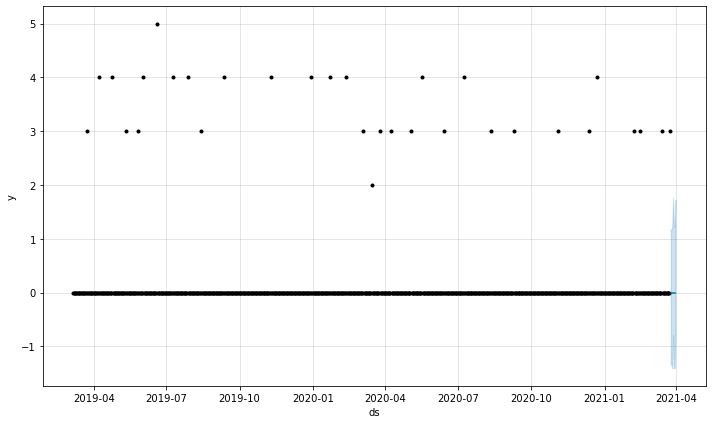

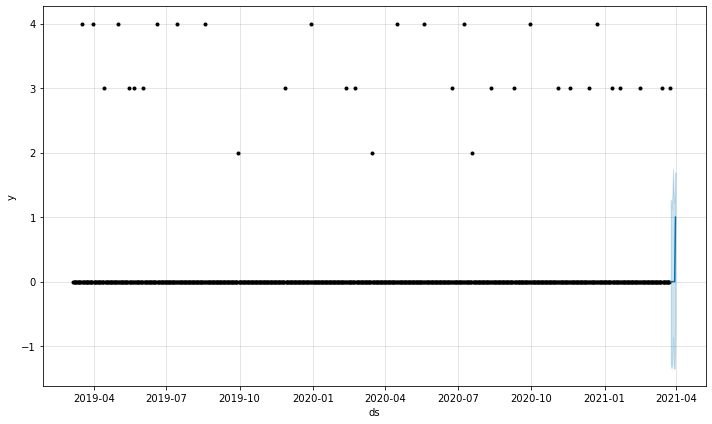

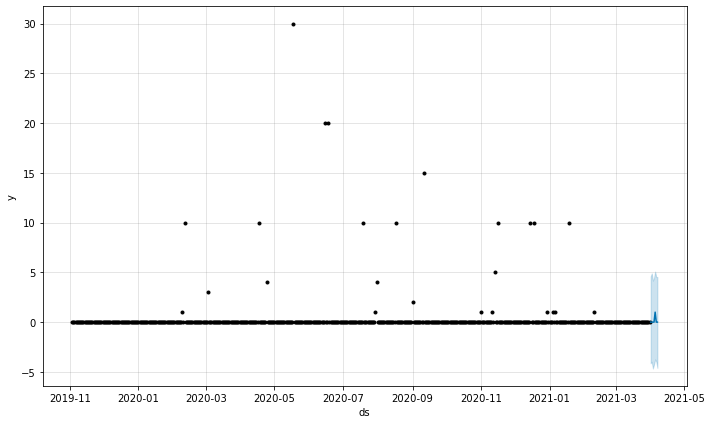

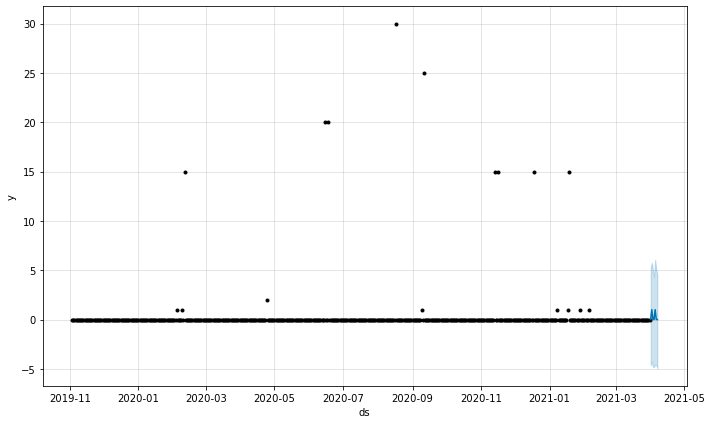

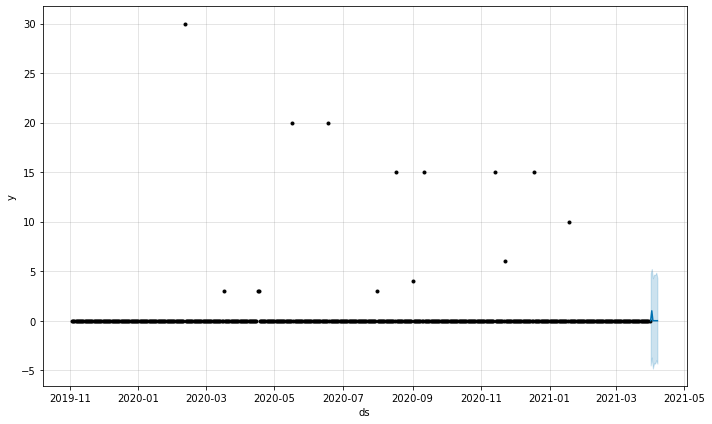

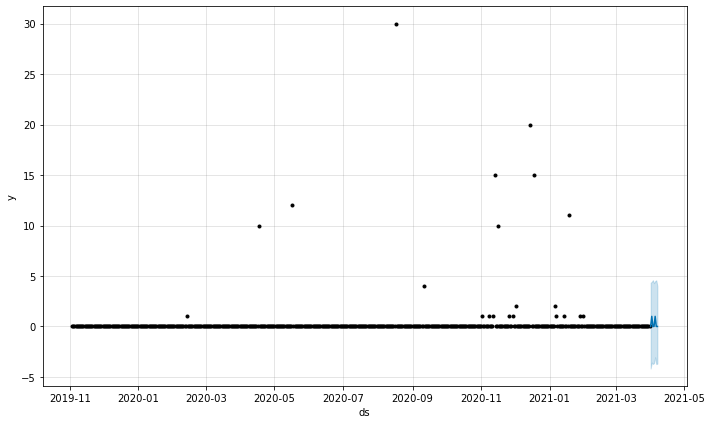

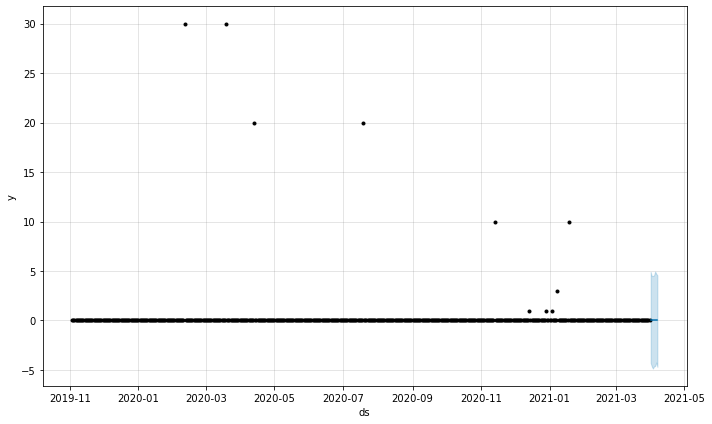

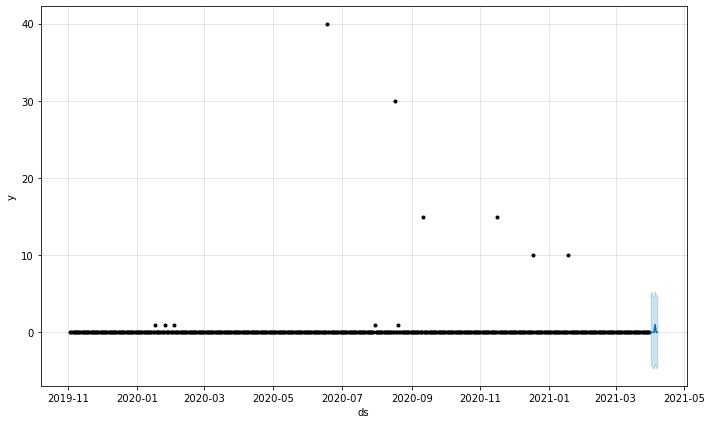

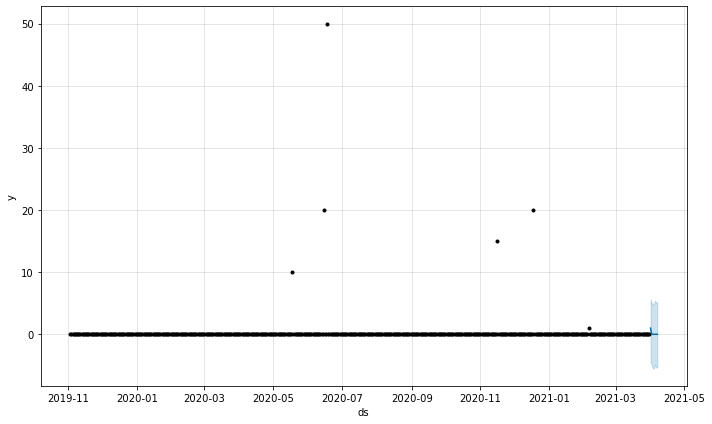

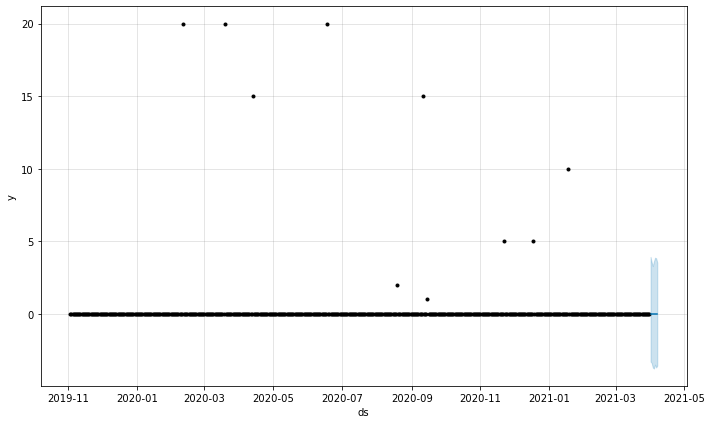

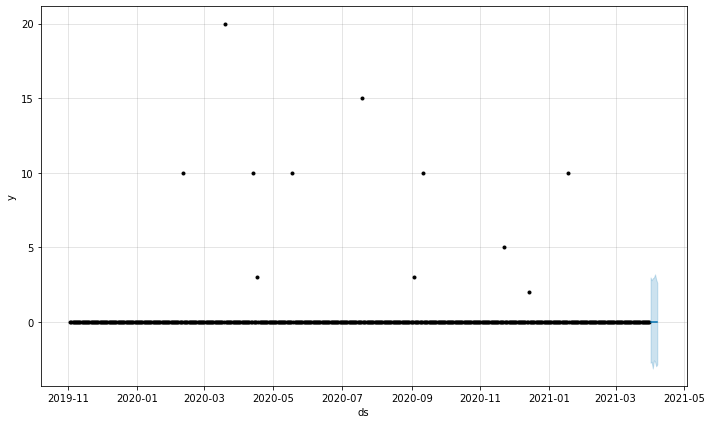

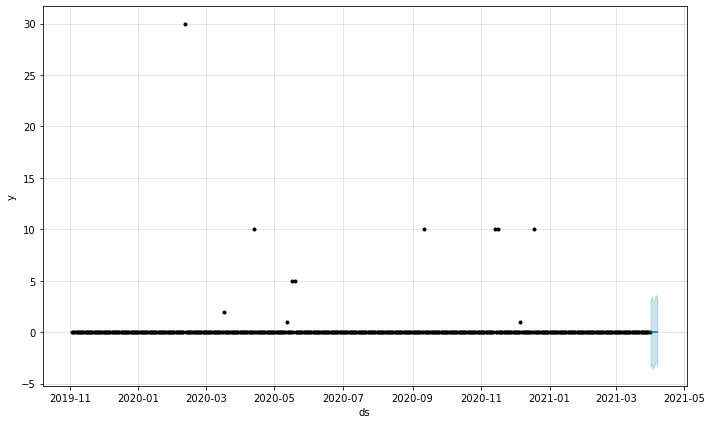

In [42]:
for store in stores_data:
    print(f'Store: {store}')
    for product in stores_data[store]['top_products_sales']:
        print(f'Product: {product}')
        stores_data[store]['fbp_objects'][product].plot(stores_data[store]['predictions'][product])

